In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#
import sys
sys.path.append('../../')
import data.datasets as datasets
from models.losses import SupervisedSimCLRLoss
#from models.networks import CustomEfficientNet
from models.networks import MLP
from models.litmodels import SimCLRModel
import data.data_utils as dutils

In [44]:
nsigs=3
ndisc=1
nrand=1
nj_train   = 10000
nj_valid   = 5
nj_testy   = 10000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)
batch_size = 1000
trainloader = torch.utils.data.DataLoader(tjds.train_dataset, batch_size=batch_size, shuffle=True)


Mins: [0, 0, 0.4699865031437509] 
Maxs: [1, 1, 0.51780330338896] 
Peaks: [0.05, 0.95, 0.5070938019344876]
Mixing
Mixing
Mixing
Mixing
Mixing


/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.59s/it]


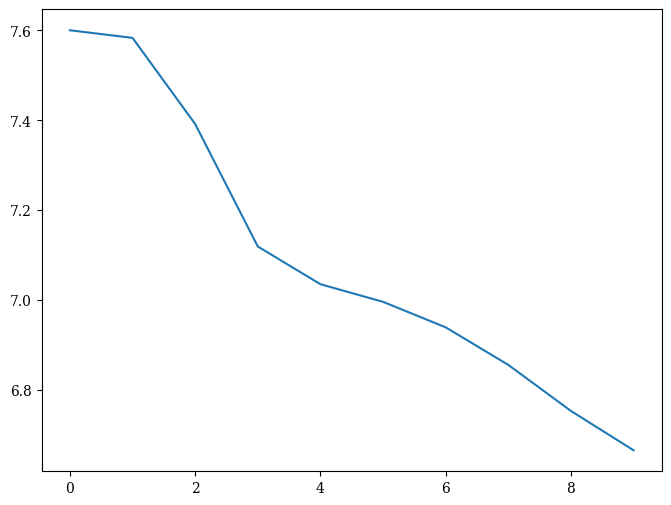

In [25]:
num_epochs=10
#now contrastive model
input_dim  = tjds.train_data.shape[1]
hidden_dims= [128,64,32,16]
embed_dim  = 4 #not making it smaller than input space
temp = 0.1
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-3)
dutils.train_aug(num_epochs,trainloader,model,criterion,optimizer)

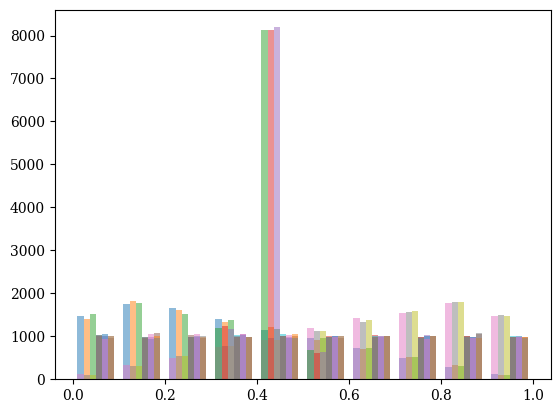

In [40]:
#plot the data
label=tjds.train_labels
#print(len(label[label==1]),len(tjds.train_data[label==0]))
plt.hist(tjds.train_data[label==0],alpha=0.5)
plt.hist(tjds.train_data[label==1],alpha=0.5)
plt.hist(tjds.train_data[label==2],alpha=0.5)
plt.hist(tjds.train_data[label==3],alpha=0.5)
plt.show()

In [45]:
#now contrastive model
input_dim  = tjds.train_data.shape[1]
hidden_dims= [128,64,32,16]
embed_dim  = 4 #not making it smaller than input space
temp = 0.1
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-3)

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:27<00:00,  1.08it/s]


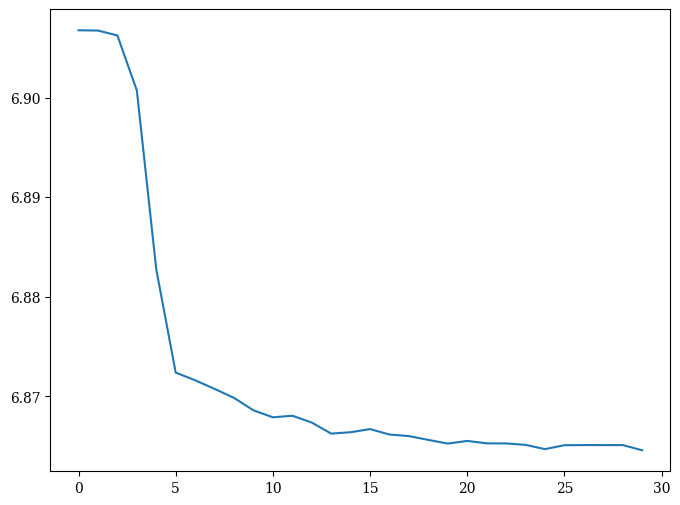

In [46]:
# Training loop
num_epochs = 30
batch_size = 1000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.08s/it]


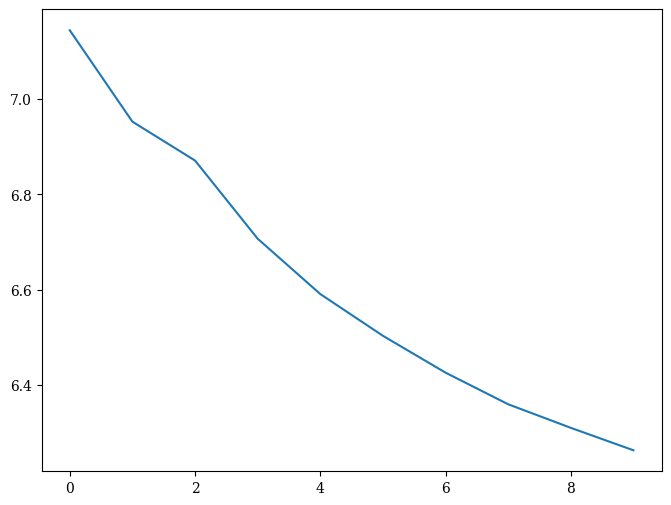

In [16]:
num_epochs = 10
batch_size = 1000
#optimizer_nl = torch.optim.AdamW(model_nl.parameters(), lr=0.1e-1)
#criterion_nl = SupervisedSimCLRLoss(temperature=temp)
# Dataloaders
trainloader_aug = torch.utils.data.DataLoader(tjds.train_dataset, batch_size=batch_size, shuffle=True)
dutils.train_aug(num_epochs,trainloader_aug,model,criterion,optimizer)


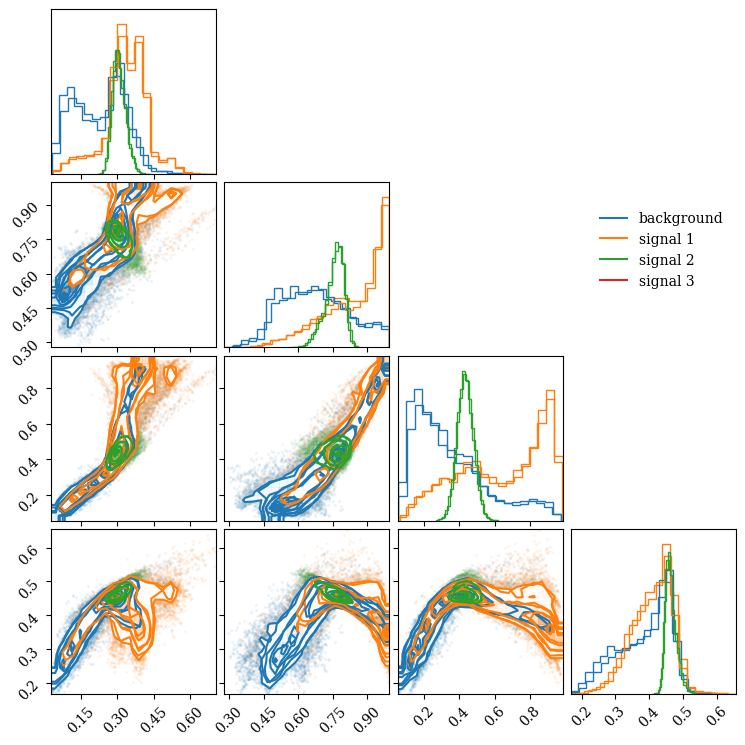

In [47]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model(tjds.test_data.float(),embed=True))
    output1 = (model(tjds.true_data.float(),embed=True))

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
corner.corner(output[labels==1].numpy(),fig=fig,color="C1", label='signal 1')
corner.corner(output[labels==2].numpy(),fig=fig,color="C2", label='signal 2')
#corner.corner(output[labels==3].numpy(),fig=fig,color="C3", label='signal 3')
corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='data background')
corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal 1')
corner.corner(output1[labels1==2].numpy(),fig=fig,color="C2", label='data signal 2')
#corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 3')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='signal 1'),
            mlines.Line2D([], [], color="C2", label='signal 2'),
            mlines.Line2D([], [], color="C3", label='signal 3'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


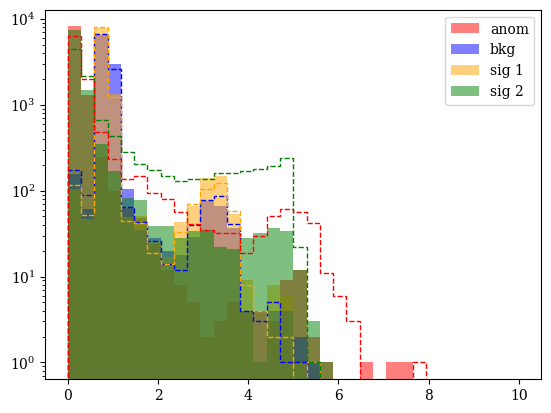

AUC: tensor(0.9842)


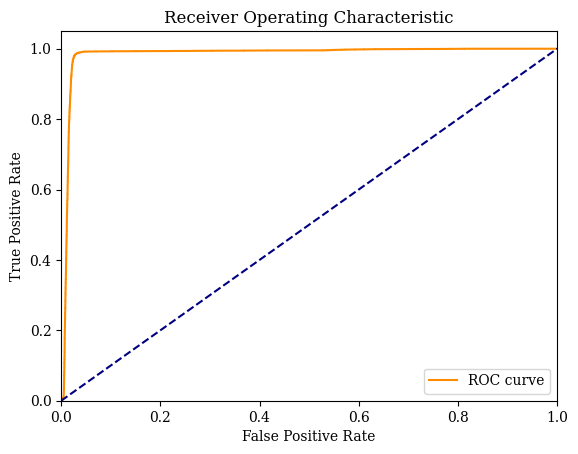

AUC: tensor(0.9450)


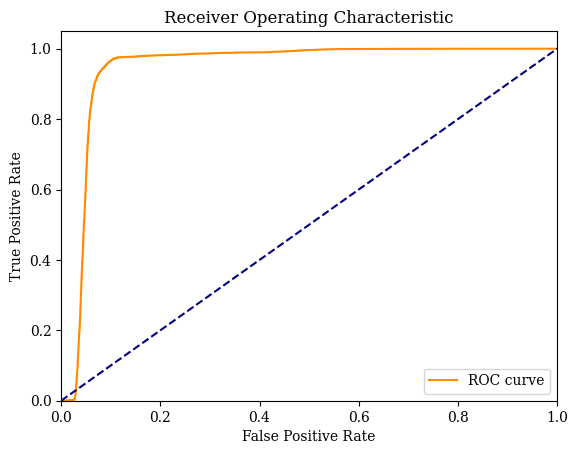

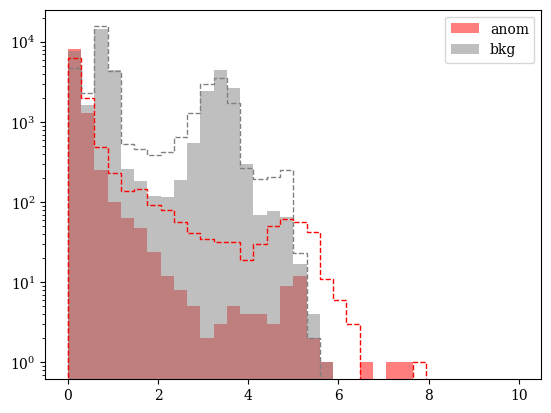

In [20]:
#Phil's simplified manahalobis distance
dist=dutils.approxDist(output, output, labels, nsigs-1)
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
#plt.yscale('log')
#plt.legend()
#plt.show()

dist1=dutils.approxDist(output1, output, labels, nsigs-1)
#bins=np.linspace(0,10.,15)
plt.hist(dist1[labels1==0],bins=bins,facecolor='none', edgecolor='blue',histtype='step',linestyle='--')
plt.hist(dist1[labels1==1],bins=bins,facecolor='none', edgecolor='orange',histtype='step',linestyle='--')
plt.hist(dist1[labels1==2],bins=bins,facecolor='none', edgecolor='green',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

dutils.approxAUC(dist,  labels, nsigs)
dutils.approxAUC(dist1, labels1, nsigs)


plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels!=3],bins=bins,alpha=0.5,color='grey',label='bkg')
plt.hist(dist1[labels1!=3],bins=bins,facecolor='none', edgecolor='grey',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()


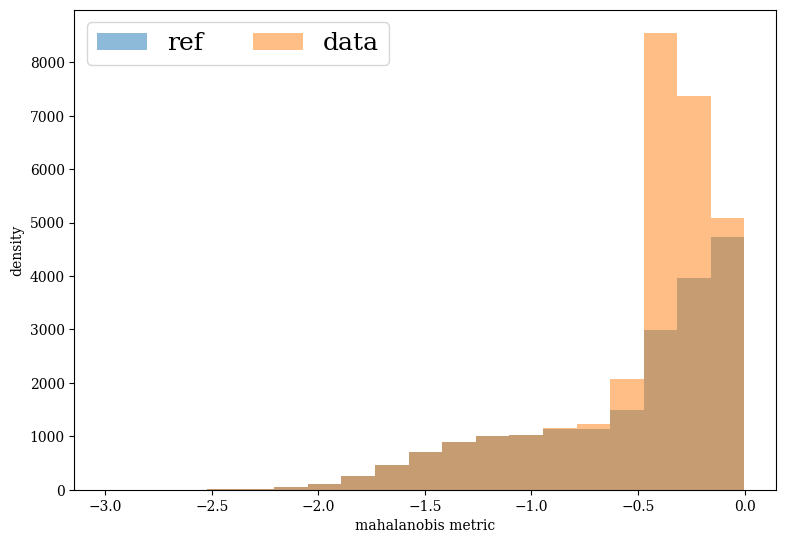

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 19
    # variables        = 1
    chi-square         = 8516.27014
    reduced chi-square = 473.126119
    Akaike info crit   = 118.000601
    Bayesian info crit = 118.945040
    R-squared          = 0.99992703
[[Variables]]
    a2:  1.50000000 +/- 0.15380607 (10.25%) (init = 1)


/Users/philipharris/miniconda3/lib/python3.10/site-packages/lmfit/model.py:994: UserWarning: The keyword argument iTck does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

In [48]:
ref=output[labels != 2]
ref_label=labels[labels != 2]
val,dist=dutils.mahalanobis_dist(output,ref,ref_label,fit=True)
#dist.plot()
bins=np.linspace(0,30.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
plt.legend()
plt.yscale('log')

In [ ]:
dutils.run_toy(100, 1000, 10000, output,labels,output,labels,3)

In [9]:
embedder_full   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector_full  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model_full = SimCLRModel(embedder_full, projector_full)
criterion_full = SupervisedSimCLRLoss(temperature=temp)
optimizer_full = torch.optim.AdamW(model_full.parameters(), lr=0.5e-2)

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:34<00:00,  1.67s/it]


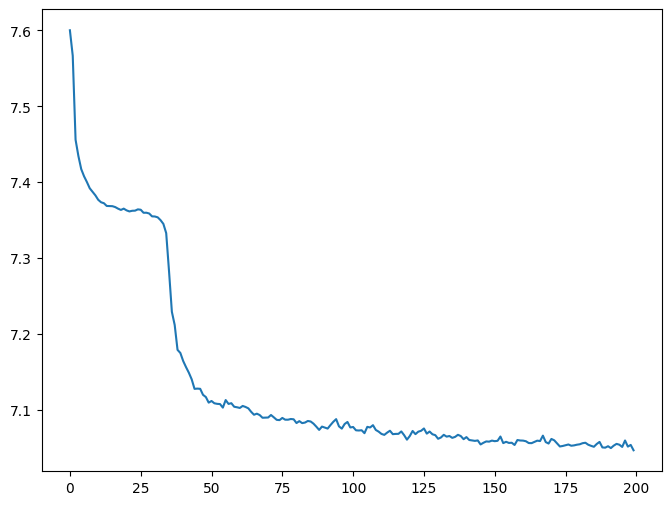

In [10]:
# Training loop
num_epochs = 200
batch_size = 2000
# Dataloaders
trainloader_full = torch.utils.data.DataLoader(tjds.train_dataset_basic_full, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader_full,model_full,criterion_full,optimizer_full)

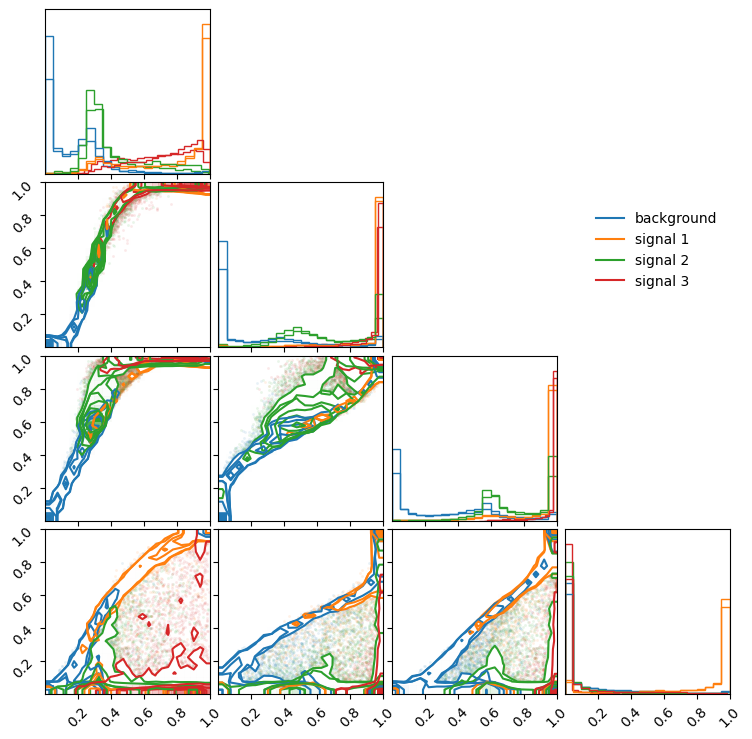

In [11]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model_full(tjds.test_data.float(),embed=True))
    output1 = (model_full(tjds.true_data.float(),embed=True))

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
corner.corner(output[labels==1].numpy(),fig=fig,color="C1", label='signal 1')
corner.corner(output[labels==2].numpy(),fig=fig,color="C2", label='signal 2')
corner.corner(output[labels==3].numpy(),fig=fig,color="C3", label='signal 3')
corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='data background')
corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal 1')
corner.corner(output1[labels1==2].numpy(),fig=fig,color="C2", label='data signal 2')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 3')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='signal 1'),
            mlines.Line2D([], [], color="C2", label='signal 2'),
            mlines.Line2D([], [], color="C3", label='signal 3'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


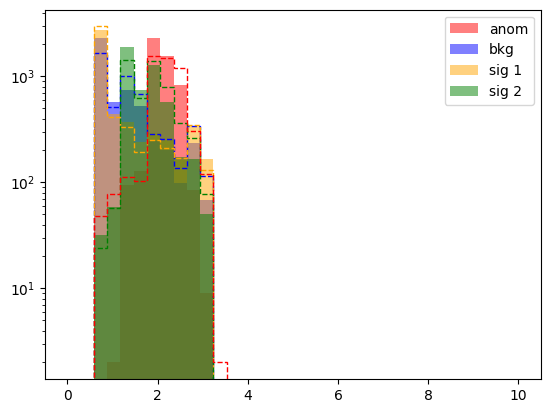

AUC: tensor(0.8278)


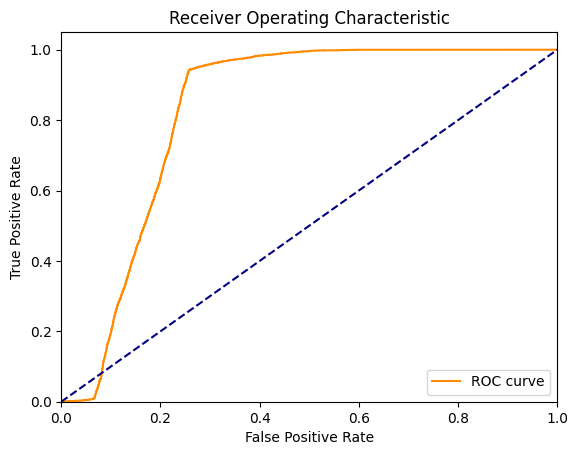

AUC: tensor(0.8011)


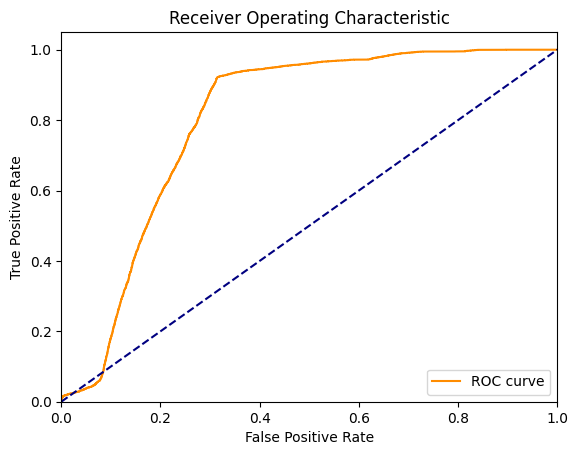

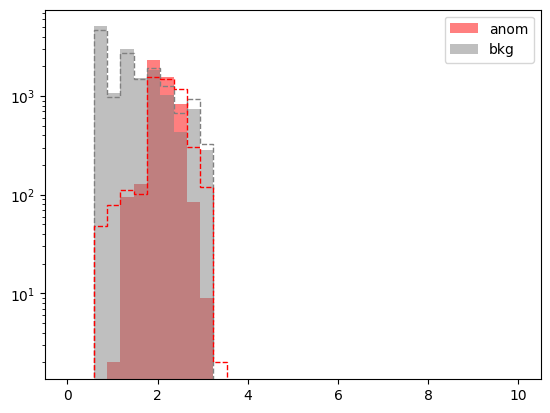

In [12]:
dist=dutils.approxDist(output, output, labels, nsigs-1)
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
#plt.yscale('log')
#plt.legend()
#plt.show()

dist1=dutils.approxDist(output1, output, labels, nsigs-1)
#bins=np.linspace(0,10.,15)
plt.hist(dist1[labels1==0],bins=bins,facecolor='none', edgecolor='blue',histtype='step',linestyle='--')
plt.hist(dist1[labels1==1],bins=bins,facecolor='none', edgecolor='orange',histtype='step',linestyle='--')
plt.hist(dist1[labels1==2],bins=bins,facecolor='none', edgecolor='green',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

dutils.approxAUC(dist,  labels, nsigs)
dutils.approxAUC(dist1, labels1, nsigs)


plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels!=3],bins=bins,alpha=0.5,color='grey',label='bkg')
plt.hist(dist1[labels1!=3],bins=bins,facecolor='none', edgecolor='grey',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()


In [25]:
nsigs=4
ndisc=4
nrand=0
nj_train   = 20000
nj_valid   = 5
nj_testy   = 20000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)

 Mins: [0, 0, 0.07696627150179669, 0.3386658078952267] 
 Maxs: [1, 1, 0.9312748153680579, 0.7706797984203926] 
 Peaks: [0.05, 0.95, 0.2655634084918845, 0.7084932372737425]


In [26]:
input_dim  = tjds.train_data.shape[1]
hidden_dims= [128,64,32,16]
embed_dim  = 4
temp = 0.1
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-2)

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:32:58<00:00, 27.89s/it]


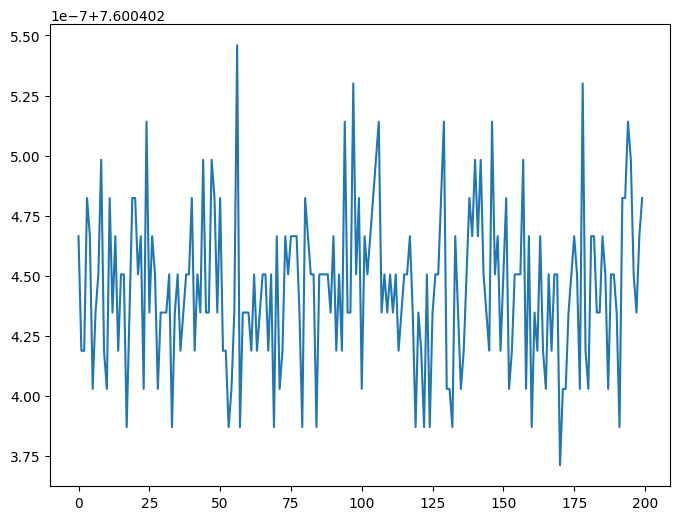

In [27]:
# Training loop
num_epochs = 200
batch_size = 2000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

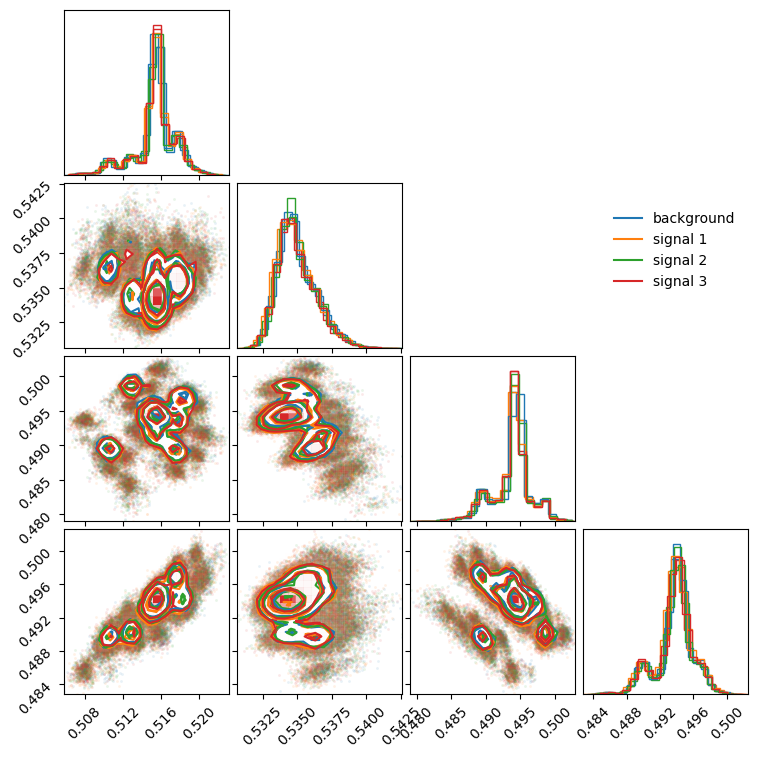

In [28]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model(tjds.test_data.float(),embed=True))
    output1 = (model(tjds.true_data.float(),embed=True))

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
corner.corner(output[labels==1].numpy(),fig=fig,color="C1", label='signal 1')
corner.corner(output[labels==2].numpy(),fig=fig,color="C2", label='signal 2')
corner.corner(output[labels==3].numpy(),fig=fig,color="C3", label='signal 3')
corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='data background')
corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal 1')
corner.corner(output1[labels1==2].numpy(),fig=fig,color="C2", label='data signal 2')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 3')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='signal 1'),
            mlines.Line2D([], [], color="C2", label='signal 2'),
            mlines.Line2D([], [], color="C3", label='signal 3'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


In [29]:
ist=dutils.approxDist(output, output, labels, nsigs-1)
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
#plt.yscale('log')
#plt.legend()
#plt.show()

dist1=dutils.approxDist(output1, output, labels, nsigs-1)
#bins=np.linspace(0,10.,15)
plt.hist(dist1[labels1==0],bins=bins,facecolor='none', edgecolor='blue',histtype='step',linestyle='--')
plt.hist(dist1[labels1==1],bins=bins,facecolor='none', edgecolor='orange',histtype='step',linestyle='--')
plt.hist(dist1[labels1==2],bins=bins,facecolor='none', edgecolor='green',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

dutils.approxAUC(dist,  labels, nsigs)
dutils.approxAUC(dist1, labels1, nsigs)


plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels!=3],bins=bins,alpha=0.5,color='grey',label='bkg')
plt.hist(dist1[labels1!=3],bins=bins,facecolor='none', edgecolor='grey',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()


IndexError: The shape of the mask [80000] at index 0 does not match the shape of the indexed tensor [20000] at index 0

In [ ]:
embedder_full   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector_full  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model_full = SimCLRModel(embedder_full, projector_full)
criterion_full = SupervisedSimCLRLoss(temperature=temp)
optimizer_full = torch.optim.AdamW(model_full.parameters(), lr=0.5e-2)

In [ ]:
# Training loop
num_epochs = 200
batch_size = 2000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

In [ ]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model_full(tjds.test_data.float(),embed=True))
    output1 = (model_full(tjds.true_data.float(),embed=True))

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
corner.corner(output[labels==1].numpy(),fig=fig,color="C1", label='signal 1')
corner.corner(output[labels==2].numpy(),fig=fig,color="C2", label='signal 2')
corner.corner(output[labels==3].numpy(),fig=fig,color="C3", label='signal 3')
corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='data background')
corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal 1')
corner.corner(output1[labels1==2].numpy(),fig=fig,color="C2", label='data signal 2')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 3')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='signal 1'),
            mlines.Line2D([], [], color="C2", label='signal 2'),
            mlines.Line2D([], [], color="C3", label='signal 3'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


In [ ]:
dist=dutils.approxDist(output, output, labels, nsigs-1)
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
#plt.yscale('log')
#plt.legend()
#plt.show()

dist1=dutils.approxDist(output1, output, labels, nsigs-1)
#bins=np.linspace(0,10.,15)
plt.hist(dist1[labels1==0],bins=bins,facecolor='none', edgecolor='blue',histtype='step',linestyle='--')
plt.hist(dist1[labels1==1],bins=bins,facecolor='none', edgecolor='orange',histtype='step',linestyle='--')
plt.hist(dist1[labels1==2],bins=bins,facecolor='none', edgecolor='green',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

dutils.approxAUC(dist,  labels, nsigs)
dutils.approxAUC(dist1, labels1, nsigs)


plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels!=3],bins=bins,alpha=0.5,color='grey',label='bkg')
plt.hist(dist1[labels1!=3],bins=bins,facecolor='none', edgecolor='grey',histtype='step',linestyle='--')
plt.hist(dist1[labels1==3],bins=bins,facecolor='none', edgecolor='red',histtype='step',linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()


In [23]:
nsigs   = np.random.poisson(lam=30, size=100)
print(nsigs)
sigidx  = np.random.choice(5000, size=nsigs, replace=False)
print(sigidx)

[27 36 26 39 26 32 30 23 23 28 28 21 33 28 28 28 34 23 34 28 30 26 30 35
 18 28 30 31 29 32 26 28 25 31 24 32 25 31 38 21 27 35 37 17 25 31 33 31
 28 25 31 34 36 35 27 33 30 27 31 37 23 31 21 31 34 37 36 23 30 26 26 19
 27 30 31 33 29 30 24 40 39 23 36 20 30 34 31 35 32 25 34 35 33 33 34 26
 49 25 29 30]


ValueError: maximum supported dimension for an ndarray is 32, found 100

In [82]:
1.5 % 1.0


0.5

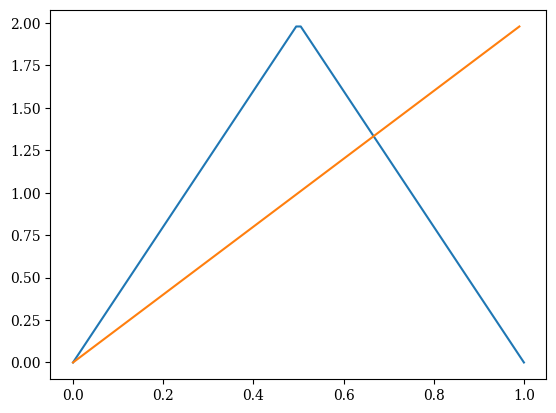

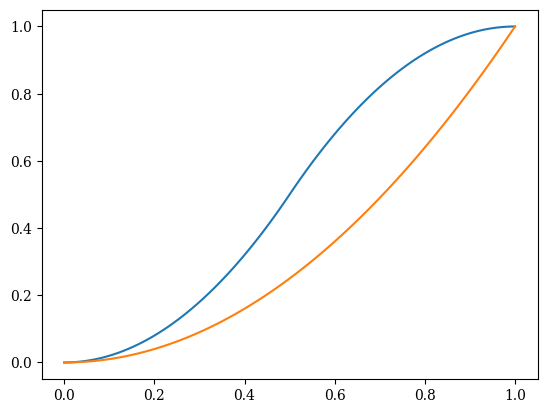

In [29]:
def triangular_pdf(x, a, b, c):
    x = np.asarray(x)
    pdf = np.zeros_like(x, dtype=float)

    # Rising edge: a <= x < c
    mask1 = (x >= a) & (x < c)
    pdf[mask1] = 2 * (x[mask1] - a) / ((b - a) * (c - a))

    # Falling edge: c <= x <= b
    mask2 = (x >= c) & (x <= b)
    pdf[mask2] = 2 * (b - x[mask2]) / ((b - a) * (b - c))
    
    return pdf

def triangular_cdf(x, a, b, c):
    x = np.asarray(x)
    cdf = np.zeros_like(x, dtype=float)

    # Case: a < x <= c
    mask1 = (x > a) & (x <= c)
    cdf[mask1] = ((x[mask1] - a) ** 2) / ((b - a) * (c - a))

    # Case: c < x < b
    mask2 = (x > c) & (x < b)
    cdf[mask2] = 1 - ((b - x[mask2]) ** 2) / ((b - a) * (b - c))

    # Case: x >= b
    mask3 = (x >= b)
    cdf[mask3] = 1.0

    return cdf
    
def triangular_int(xmin,xmax,a,b,c):
    lMin=triangular_cdf(xmin,a,b,c)
    lMax=triangular_cdf(xmax,a,b,c)
    return lMax-lMin
    
def pairwise_max(iD,t1=[],t2=[],iNSig=1e2,iNBkg=1e4):
    xrange=np.linspace(0,1,100)
    c_val = t1[2]
    ints1=triangular_int(c_val-xrange,c_val+xrange,t1[0],t1[1],t1[2])
    ints2=triangular_int(c_val-xrange,c_val+xrange,t2[0],t2[1],t2[2])
    vals=ints1[1:-1]*iNSig/(np.sqrt(ints2[1:-1]*iNBkg))
    print(vals)
    maxval=(np.max(vals[(vals > 0) & (vals < 1e1)]))**iD
    #return vals**iD
    return maxval
    
    
def nvars(iD,iNSigs,iNTries=1000,iSigCut=3, iSigMax=4):
    mins =[]
    maxs =[]
    peaks=[]
    mins.append(0); maxs.append(1); peaks.append(0.05)
    mins.append(0); maxs.append(1); peaks.append(1.-0.05)
    print("Max:",pairwise_max(iD,[0,1,0.05],[0,1,0.95]))
    ntries=0
    for pSig in range(2,iNSigs):
        pPass  = False
        ntries = 0
        pMin = pMax = pPeak = 0
        while pPass == False:
            pMin  = np.random.uniform(0,0.5)
            pMax  = np.random.uniform(0.5,1.0)
            pPeak = np.random.uniform(pMin,pMax)
            tMax = 5
            for pVal in range(len(mins)):
                testMax =  pairwise_max(iD,[pMin,pMax,pPeak],[mins[pVal],maxs[pVal],peaks[pVal]])
                if  tMax > testMax:
                    tMax = testMax
            
            if iSigMax > tMax > iSigCut or ntries > 999:
                pPass = True
            ntries += 1
        if ntries < 1000:
            mins.append(pMin)
            maxs.append(pMax)
            peaks.append(pPeak)
        else:
            print("too many tries, reconfigure",ntries)
    print("Mins:",mins,"\nMaxs:",maxs,"\nPeaks:",peaks)


x=np.linspace(0,1,100)
plt.plot(x,triangular_pdf(x,0,1,0.5))
plt.plot(x,triangular_pdf(x,0,1,1))
plt.show()

plt.plot(x,triangular_cdf(x,0,1,0.5))
plt.plot(x,triangular_cdf(x,0,1,1))
plt.show()

#plt.plot(x,pairwise_max(10,[0,1,0.5],[0,1,1]))
#plt.show()

#nvars(2,5)
#nsigs=3

In [34]:
pairwise_max(1,[0.2876889917789985,0.5950547024846812, 0.543027741828855],[0.35501756511947924, 0.5086156645009046, 0.42557316653604804])

[       inf        inf        inf 7.59446549 3.26509677 2.22835326
 1.7601263  1.48944826 1.31036077 1.18118886 1.08221137 1.00493904
 0.95865648 0.93334389 0.92110962 0.91807602 0.92226841 0.93277904
 0.94875231 0.96377699 0.97620159 0.98602611 0.99325053 0.99787488
 0.99989914 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


7.594465485202216

In [23]:
np.random.choice(np.arange(3),3,replace=False)

array([2, 1, 0])